In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.style.use(['ggplot'])
plt.rcParams['figure.figsize'] = [12, 4]


# General functions

In [32]:
rho = 998  # water density [kg/m3]
g = 9.80665  # gravitational acceleration [m/s2]
f = 0.0225  # friction factor [%/100]

velocity_fun = lambda q, d: 4 * q / (np.pi * (d ** 2))  # discharge velocity [m/s]
hn_fun = lambda hg, q, l, d: hg - f * l * velocity_fun(q, d) ** 2 / (d * 2 * g)  # net head [m]
power_fun = lambda hg, q, l, d: rho * g * q * hn_fun(hg, q, l, d) / 1e6  # power [MW]
pq_fun = lambda hg, q, l, d: np.array([power_fun(hg0, q, l, d) for hg0 in hg]).T

# KWA (Altstafel)

{0: {'vmin_piece': 1441251.0, 'head': 0.003546400451302509, 'vmax_piece': 2681645.375, 'beta': 0}, 1: {'vmin_piece': 2681645.375, 'head': 0.0035954337013025094, 'vmax_piece': 4306794.5, 'beta': 0}, 2: {'vmin_piece': 4306794.5, 'head': 0.0036444669513025093, 'vmax_piece': 6266599.5, 'beta': 0}, 3: {'vmin_piece': 6266599.5, 'head': 0.0036935002013025096, 'vmax_piece': 8457472.625, 'beta': 0}, 4: {'vmin_piece': 8457472.625, 'head': 0.00374253345130251, 'vmax_piece': 10819868.25, 'beta': 0}, 5: {'vmin_piece': 10819868.25, 'head': 0.0037915667013025092, 'vmax_piece': 13323963.75, 'beta': 0}, 6: {'vmin_piece': 13323963.75, 'head': 0.003840599951302509, 'vmax_piece': 18000000.0, 'beta': 0}}


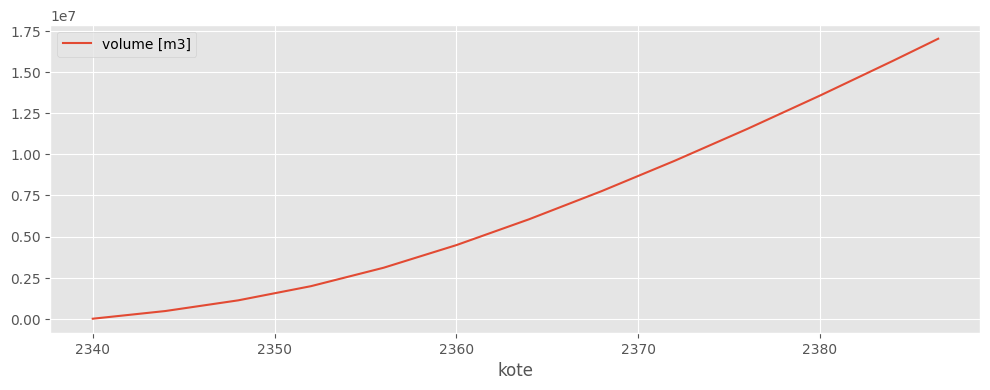

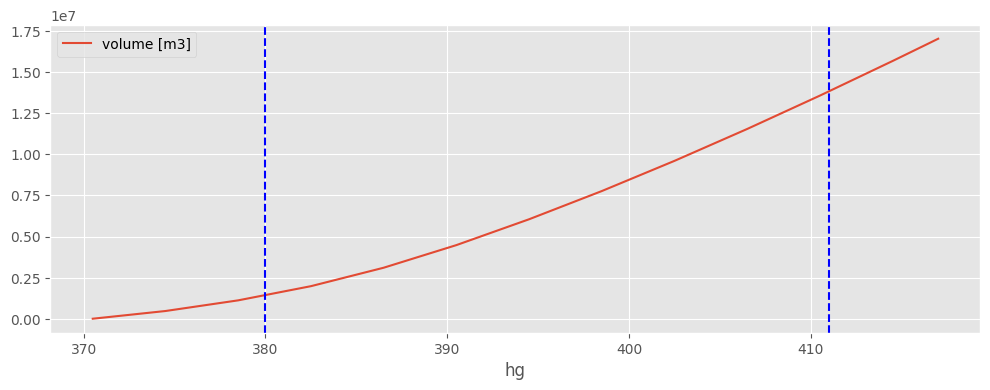

<Figure size 1200x400 with 0 Axes>

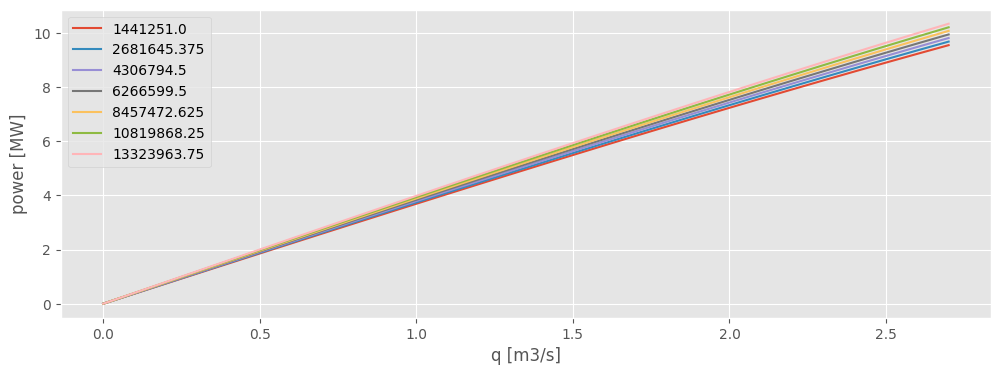

In [51]:
unit0 = {
    "l": 800,  # length of penstock [m]
    "d": 900e-3,  # diameter of penstock [m]
    "hgmaxmax": 417,  # gros head value indicated by operator [m]
    "hgmax": 411,  # gross head max [m]
    "hgmin": 380,  # gross head min [m]
    "vmax": 18e6,  # max volume [m3]
    "qn": 2.8,  # nominal flow rate [m2/s]
}

vh = pd.DataFrame({"kote": [2340, 2344, 2348, 2352, 2356, 2360, 2364, 2368, 2372, 2376, 2380, 2384, 2386, 2386.5], 
                   "volume [m3]": [0, 468927, 1117887, 1980191, 3102518, 4478834, 6052111, 7768019, 9606562, 11547852, 13577694, 15684858, 16763477, 17035683]})
vh["hg"] = vh["kote"] - vh["kote"].max() + unit0["hgmaxmax"]
vh_func = interp1d(vh.sort_values(by='hg')['hg'], vh.sort_values(by='hg')['volume [m3]'], kind='linear')

q_vec = np.arange(0, unit0["qn"], 0.1)
h_vec = np.arange(unit0["hgmin"], unit0["hgmax"], 5)

power = pq_fun(h_vec, q=q_vec, l=unit0["l"], d=unit0["d"])
power_df = pd.DataFrame(power, index=q_vec, columns=vh_func(h_vec))
if True:
    ax1 = vh.plot(x="kote", y="volume [m3]")
    ax2 = vh.plot(x="hg", y="volume [m3]")
    plt.axvline(x=unit0["hgmin"], color='b', linestyle='--')
    plt.axvline(x=unit0["hgmax"], color='b', linestyle='--')
    plt.figure()
    power_df.plot(ylabel="power [MW]", xlabel="q [m3/s]")
data = pd.DataFrame((power_df.iloc[-1, :] / (power_df.index[-1] * rho))).reset_index().rename(columns={"index": "vmin_piece", power_df.index[-1]:"head"})
data["vmax_piece"] = data["vmin_piece"].shift(-1).fillna(unit0["vmax"])
data["beta"] = 0
print(data.to_dict("index"))

# Oberwald

{0: {'vmin_piece': 0.0, 'head': 0.00018909775032092762, 'vmax_piece': 1666.6666666666667, 'beta': 0}, 1: {'vmin_piece': 1666.6666666666667, 'head': 0.0006794302503209277, 'vmax_piece': 3333.3333333333335, 'beta': 0}, 2: {'vmin_piece': 3333.3333333333335, 'head': 0.0011697627503209275, 'vmax_piece': 5000.0, 'beta': 0}, 3: {'vmin_piece': 5000.0, 'head': 0.0016600952503209273, 'vmax_piece': 6666.666666666667, 'beta': 0}, 4: {'vmin_piece': 6666.666666666667, 'head': 0.0021504277503209277, 'vmax_piece': 8333.333333333334, 'beta': 0}, 5: {'vmin_piece': 8333.333333333334, 'head': 0.0026407602503209274, 'vmax_piece': 8900.0, 'beta': 0}}


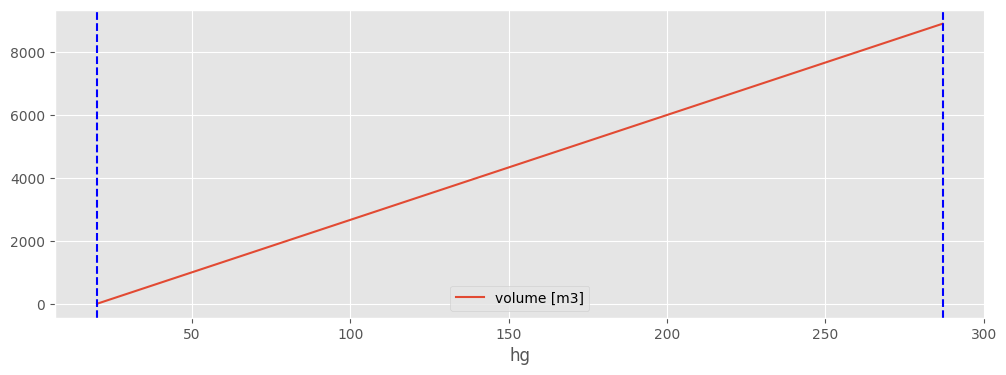

<Figure size 1200x400 with 0 Axes>

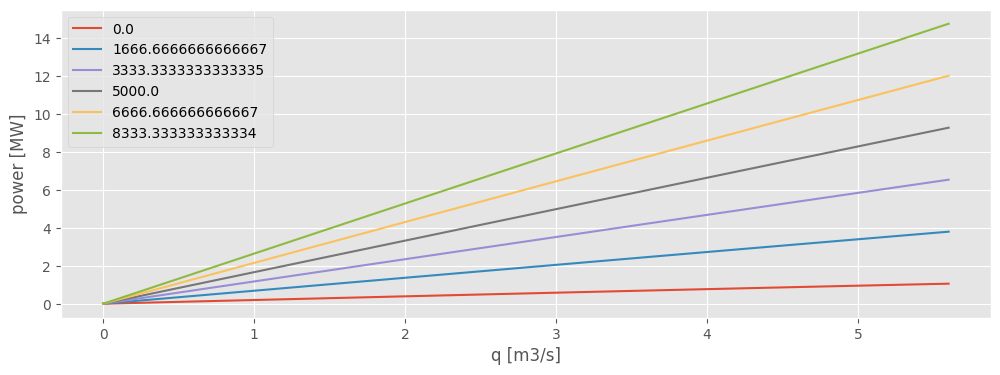

In [52]:
unit0 = {
    "l": 2117,  # length of penstock [m]
    "d": 2800e-3,  # diameter of penstock [m]
    "hgmax": 287,  # gross head [m]
    "hgmin": 20,
    "hgmaxmax": 287,
    "vmax": 8900,
    "qn": 5.7,  # nominal flow rate [m2/s]
}

vh = pd.DataFrame({"hg": [20, 287, ], 
                   "volume [m3]": [0, 8900]})
vh_func = interp1d(vh.sort_values(by='hg')['hg'], vh.sort_values(by='hg')['volume [m3]'], kind='linear')

q_vec = np.arange(0, unit0["qn"], 0.2)
h_vec = np.arange(unit0["hgmin"], unit0["hgmax"], 50)
power = pq_fun(h_vec, q=q_vec, l=unit0["l"], d=unit0["d"])

power_df = pd.DataFrame(power, index=q_vec, columns=vh_func(h_vec))
if True:
    ax2 = vh.plot(x="hg", y="volume [m3]")
    plt.axvline(x=unit0["hgmin"], color='b', linestyle='--')
    plt.axvline(x=unit0["hgmax"], color='b', linestyle='--')
    plt.figure()
    power_df.plot(ylabel="power [MW]", xlabel="q [m3/s]")

data = pd.DataFrame((power_df.iloc[-1, :] / (power_df.index[-1] * rho))).reset_index().rename(columns={"index": "vmin_piece", power_df.index[-1]:"head"})
data["vmax_piece"] = data["vmin_piece"].shift(-1).fillna(unit0["vmax"])
data["beta"] = 0
print(data.to_dict("index"))

# Merzenbach

{0: {'vmin_piece': 0.0, 'head': 1.996972954820025e-05, 'vmax_piece': 123.4504132231405, 'beta': 0}, 1: {'vmin_piece': 123.4504132231405, 'head': 0.0005103022295482001, 'vmax_piece': 246.900826446281, 'beta': 0}, 2: {'vmin_piece': 246.900826446281, 'head': 0.0010006347295482, 'vmax_piece': 370.3512396694215, 'beta': 0}, 3: {'vmin_piece': 370.3512396694215, 'head': 0.0014909672295481996, 'vmax_piece': 493.801652892562, 'beta': 0}, 4: {'vmin_piece': 493.801652892562, 'head': 0.0019812997295482, 'vmax_piece': 617.2520661157025, 'beta': 0}, 5: {'vmin_piece': 617.2520661157025, 'head': 0.0024716322295481995, 'vmax_piece': 740.702479338843, 'beta': 0}, 6: {'vmin_piece': 740.702479338843, 'head': 0.0029619647295481993, 'vmax_piece': 864.1528925619834, 'beta': 0}, 7: {'vmin_piece': 864.1528925619834, 'head': 0.003452297229548199, 'vmax_piece': 987.603305785124, 'beta': 0}, 8: {'vmin_piece': 987.603305785124, 'head': 0.003942629729548199, 'vmax_piece': 1111.0537190082646, 'beta': 0}, 9: {'vmin_p

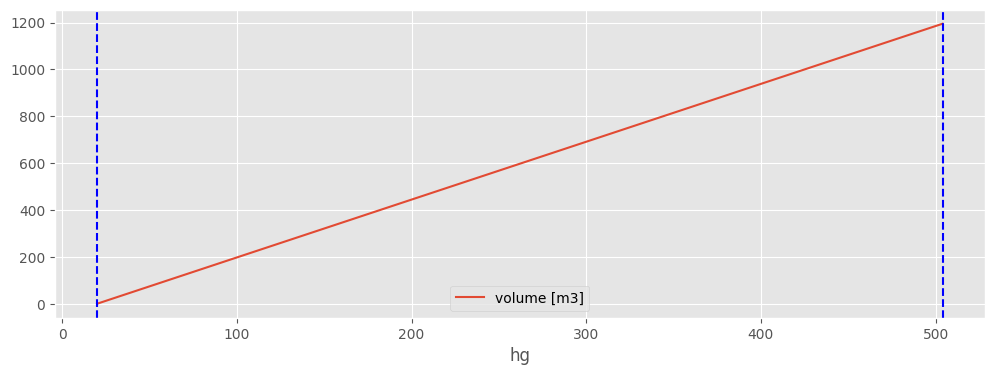

<Figure size 1200x400 with 0 Axes>

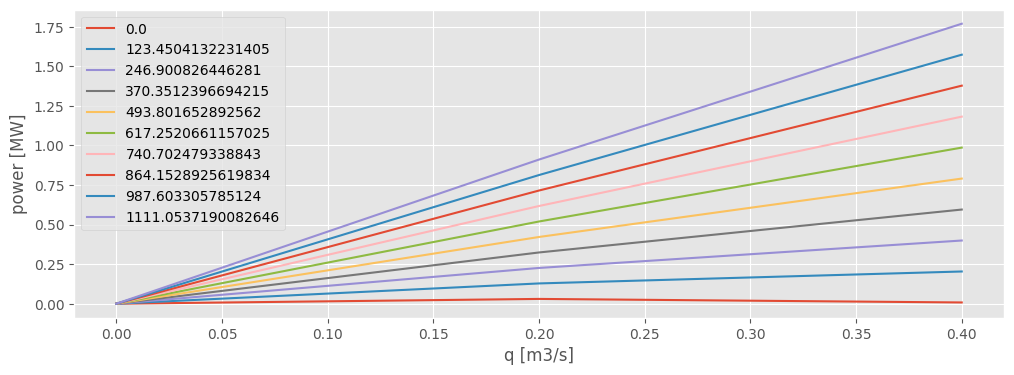

In [53]:
unit0 = {
    "l": 1114,  # length of penstock [m]
    "d": 450e-3,  # diameter of penstock [m]
    "hgmax": 504,  # gross head [m]
    "hgmin": 20,
    "hgmaxmax": 504,
    "vmax": 1195,
    "qn": 0.5,  # nominal flow rate [m2/s]
}
vh = pd.DataFrame({"hg": [20, 504, ], 
                   "volume [m3]": [0, 1195]})
vh_func = interp1d(vh.sort_values(by='hg')['hg'], vh.sort_values(by='hg')['volume [m3]'], kind='linear')

q_vec = np.arange(0, unit0["qn"], 0.2)
h_vec = np.arange(unit0["hgmin"], unit0["hgmax"], 50)
power = pq_fun(h_vec, q=q_vec, l=unit0["l"], d=unit0["d"])

power_df = pd.DataFrame(power, index=q_vec, columns=vh_func(h_vec))
if True:
    ax2 = vh.plot(x="hg", y="volume [m3]")
    plt.axvline(x=unit0["hgmin"], color='b', linestyle='--')
    plt.axvline(x=unit0["hgmax"], color='b', linestyle='--')
    plt.figure()
    power_df.plot(ylabel="power [MW]", xlabel="q [m3/s]")

data = pd.DataFrame((power_df.iloc[-1, :] / (power_df.index[-1] * rho))).reset_index().rename(columns={"index": "vmin_piece", power_df.index[-1]:"head"})
data["vmax_piece"] = data["vmin_piece"].shift(-1).fillna(unit0["vmax"])
data["beta"] = 0
print(data.to_dict("index"))

# Wannebode

{0: {'vmin_piece': 385.0331125827814, 'head': 0.00036827672545932, 'vmax_piece': 1026.7549668874171, 'beta': 0}, 1: {'vmin_piece': 1026.7549668874171, 'head': 0.0008586092254593199, 'vmax_piece': 1668.476821192053, 'beta': 0}, 2: {'vmin_piece': 1668.476821192053, 'head': 0.0013489417254593196, 'vmax_piece': 1938.0, 'beta': 0}}


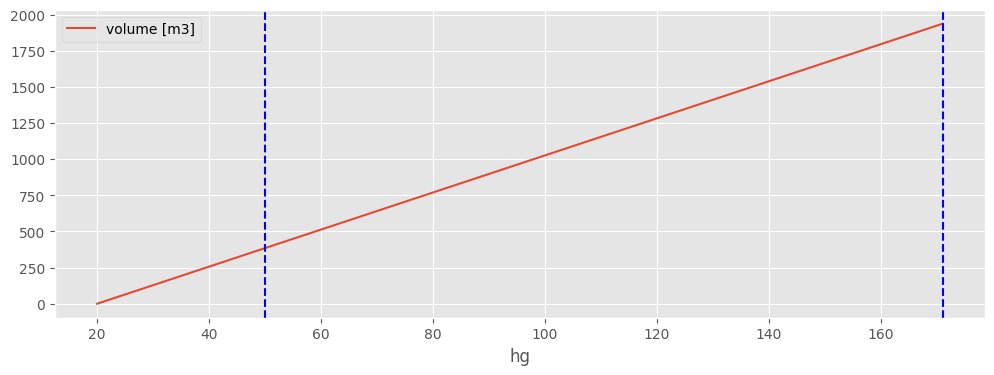

<Figure size 1200x400 with 0 Axes>

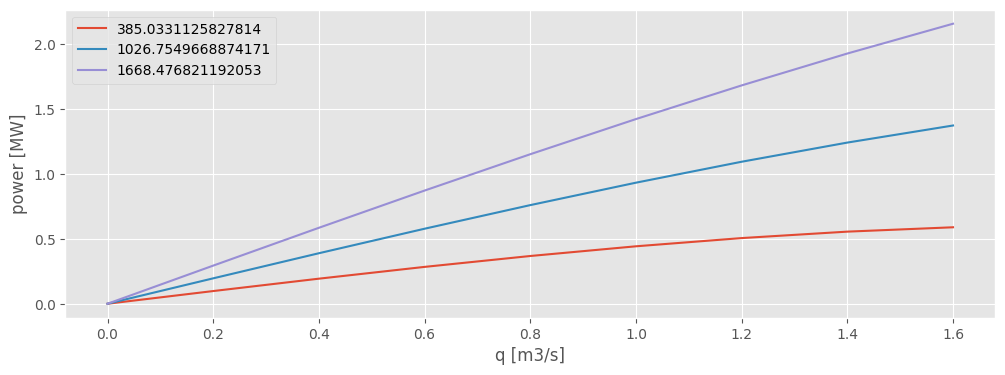

In [54]:
unit0 = {
    "l": 475,  # length of penstock [m]
    "d": 711e-3,  # diameter of penstock [m]
    "hgmax": 171,  # gross head [m]
    "hgmin": 50,
    "hgmaxmax": 171,
    "vmax": 1938,
    "qn": 1.625,  # nominal flow rate [m2/s]
}
vh = pd.DataFrame({"hg": [20, 171, ], 
                   "volume [m3]": [0, 1938]})
vh_func = interp1d(vh.sort_values(by='hg')['hg'], vh.sort_values(by='hg')['volume [m3]'], kind='linear')

q_vec = np.arange(0, unit0["qn"], 0.2)
h_vec = np.arange(unit0["hgmin"], unit0["hgmax"], 50)
power = pq_fun(h_vec, q=q_vec, l=unit0["l"], d=unit0["d"])

power_df = pd.DataFrame(power, index=q_vec, columns=vh_func(h_vec))
if True:
    ax2 = vh.plot(x="hg", y="volume [m3]")
    plt.axvline(x=unit0["hgmin"], color='b', linestyle='--')
    plt.axvline(x=unit0["hgmax"], color='b', linestyle='--')
    plt.figure()
    power_df.plot(ylabel="power [MW]", xlabel="q [m3/s]")

data = pd.DataFrame((power_df.iloc[-1, :] / (power_df.index[-1] * rho))).reset_index().rename(columns={"index": "vmin_piece", power_df.index[-1]:"head"})
data["vmax_piece"] = data["vmin_piece"].shift(-1).fillna(unit0["vmax"])
data["beta"] = 0
print(data.to_dict("index"))

# Walibach

{0: {'vmin_piece': 26.382978723404253, 'head': 0.0006410506584535405, 'vmax_piece': 59.36170212765957, 'beta': 0}, 1: {'vmin_piece': 59.36170212765957, 'head': 0.0016217156584535403, 'vmax_piece': 92.34042553191489, 'beta': 0}, 2: {'vmin_piece': 92.34042553191489, 'head': 0.00260238065845354, 'vmax_piece': 125.31914893617021, 'beta': 0}, 3: {'vmin_piece': 125.31914893617021, 'head': 0.0035830456584535395, 'vmax_piece': 158.29787234042553, 'beta': 0}, 4: {'vmin_piece': 158.29787234042553, 'head': 0.00456371065845354, 'vmax_piece': 191.27659574468083, 'beta': 0}, 5: {'vmin_piece': 191.27659574468083, 'head': 0.005544375658453538, 'vmax_piece': 224.25531914893617, 'beta': 0}, 6: {'vmin_piece': 224.25531914893617, 'head': 0.0065250406584535375, 'vmax_piece': 248.0, 'beta': 0}}


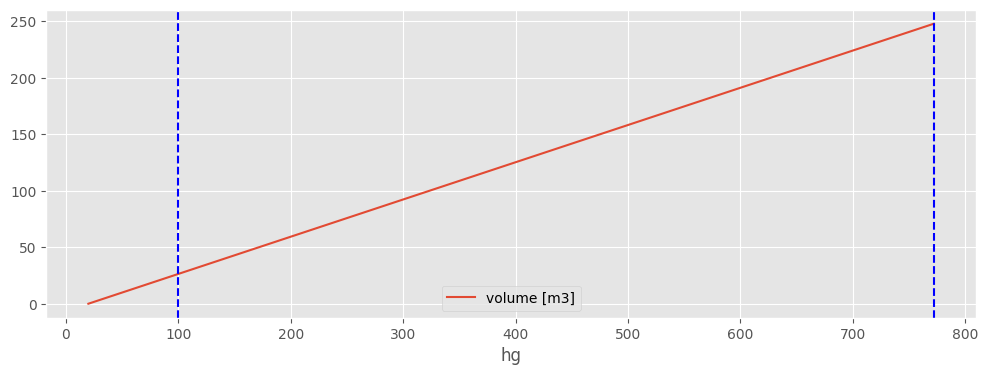

<Figure size 1200x400 with 0 Axes>

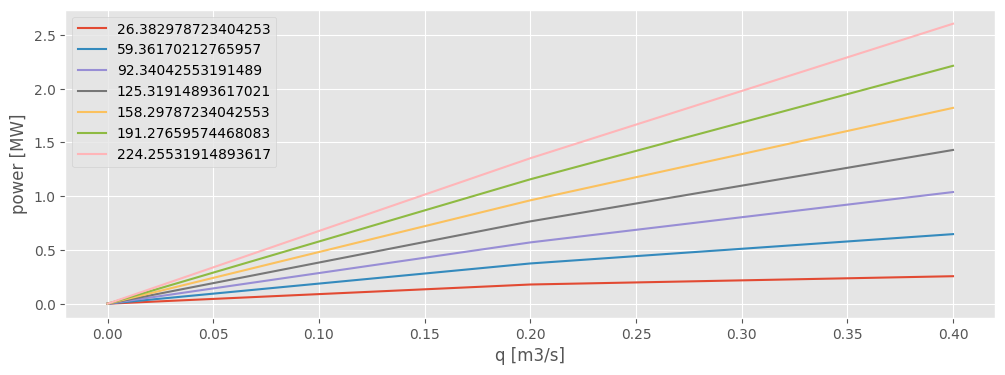

In [55]:
unit0 = {
    "l": 3637,  # length of penstock [m]
    "d": 500e-3,  # diameter of penstock [m]
    "hgmax": 772,  # gross head [m]
    "hgmin": 100,
    "hgmaxmax": 772,
    "vmax": 248,
    "qn": 0.53,  # nominal flow rate [m2/s]
}
vh = pd.DataFrame({"hg": [20, 772, ], 
                   "volume [m3]": [0, 248]})
vh_func = interp1d(vh.sort_values(by='hg')['hg'], vh.sort_values(by='hg')['volume [m3]'], kind='linear')

q_vec = np.arange(0, unit0["qn"], 0.2)
h_vec = np.arange(unit0["hgmin"], unit0["hgmax"], 100)
power = pq_fun(h_vec, q=q_vec, l=unit0["l"], d=unit0["d"])

power_df = pd.DataFrame(power, index=q_vec, columns=vh_func(h_vec))
if True:
    ax2 = vh.plot(x="hg", y="volume [m3]")
    plt.axvline(x=unit0["hgmin"], color='b', linestyle='--')
    plt.axvline(x=unit0["hgmax"], color='b', linestyle='--')
    plt.figure()
    power_df.plot(ylabel="power [MW]", xlabel="q [m3/s]")

data = pd.DataFrame((power_df.iloc[-1, :] / (power_df.index[-1] * rho))).reset_index().rename(columns={"index": "vmin_piece", power_df.index[-1]:"head"})
data["vmax_piece"] = data["vmin_piece"].shift(-1).fillna(unit0["vmax"])
data["beta"] = 0
print(data.to_dict("index"))

In [60]:
data = {0: {'vmin_piece': 26.382978723404253, 'head': 0.0006410506584535405, 'vmax_piece': 59.36170212765957, 'beta': 0}, 1: {'vmin_piece': 59.36170212765957, 'head': 0.0016217156584535403, 'vmax_piece': 92.34042553191489, 'beta': 0}, 2: {'vmin_piece': 92.34042553191489, 'head': 0.00260238065845354, 'vmax_piece': 125.31914893617021, 'beta': 0}, 3: {'vmin_piece': 125.31914893617021, 'head': 0.0035830456584535395, 'vmax_piece': 158.29787234042553, 'beta': 0}, 4: {'vmin_piece': 158.29787234042553, 'head': 0.00456371065845354, 'vmax_piece': 191.27659574468083, 'beta': 0}, 5: {'vmin_piece': 191.27659574468083, 'head': 0.005544375658453538, 'vmax_piece': 224.25531914893617, 'beta': 0}, 6: {'vmin_piece': 224.25531914893617, 'head': 0.0065250406584535375, 'vmax_piece': 248.0, 'beta': 0}}
qn = 0.53
import pandas as pd
import numpy as np
import altair as alt
# from vega_datasets import data

df = pd.DataFrame(data)

q_vec = np.arange(0, qn, 0.1)

results = pd.DataFrame(columns=["dv", "q", "power"])
for i, d in data.items():
    head = d["head"]
    beta = d["beta"]
    dv = "[" + str(int(d["vmin_piece"])) + "-" + str(int(d["vmax_piece"])) + "]"
    power = (q_vec * 998 * head + beta )
    power_df = pd.DataFrame(power, columns=["power"])
    power_df["q"] = q_vec
    power_df["dv"] = dv
    results = pd.concat([results, power_df])

base = alt.Chart(results).encode(
    alt.Color("dv").legend(None)
).transform_filter(
    "datum.dv !== 'IBM'"
).properties(
    width=500
)

line = base.mark_line().encode(x="q", y="power")


last_power = base.mark_circle().encode(
    alt.X("last_q['q']:Q"),
    alt.Y("last_q['power']:Q")
).transform_aggregate(
    last_q="argmax(q)",
    groupby=["dv"]
)

volume_name = last_power.mark_text(align="left", dx=4).encode(text="dv")

chart = (line + last_power + volume_name).encode(
    x=alt.X().title("q"),
    y=alt.Y().title("power")
)

chart


alt.LayerChart(...)